The goal of this section is to numerically simulate myopic and astigmatic defocus while taking diffraction into account.

Recall the equation for amplitude from Diffraction Part 4:

$$\begin{align}
\psi_i(x_o,y_o,x_i,y_i) &= \frac{\psi_0}{\lambda^2 z_o z_i} \exp{ \left[ \frac{ik}{2z_o} (x_o^2 + y_o^2) \right]} \exp{ \left[ \frac{ik}{2z_i} (x_i^2 + y_i^2) \right] } \times \\
& \iint_{-\infty}^{\infty} P(x_l', y_l') \exp{ \left[ \frac{ik}{2} \left( x_l'^2 + y_l'^2 \right) \left( -\frac{1}{f} + \frac{1}{z_o} + \frac{1}{z_i} \right) \right] } \exp{ \left\{ -ik \left[ \left( \frac{x_o}{z_o} + \frac{x_i}{z_i} \right) x_l' + \left( \frac{y_o}{z_o}+\frac{y_i}{z_i} \right)y_l' \right] \right\} }dx_l' dy_l'
\end{align}$$



Let's make the following simplifications. First change variables to angles. We flip the sign of image coordinates to more naturally match the image and object variables in the convolution term later on.

$$\theta_{xo} = \frac{x_o}{z_o} , \theta_{yo} = \frac{y_o}{z_o}, \theta_{xi} = - \frac{x_i}{z_i}, \theta_{yi} = - \frac{y_i}{z_i}$$
$$\theta_o^2 = \theta_{xo}^2 + \theta_{yo}^2$$
$$\theta_i^2 = \theta_{xi}^2 + \theta_{yi}^2$$

Second we will drop the exponential $\left( \frac{ikz_i}{2} \theta_i^2 \right)$ term since we don't care about the phase at the image, only the intensity.

Third we will define the pupil to be a circular aperture and switch to a bounded integral:

$$P(x_l',y_l') = \begin{cases} 1, & r_l'^2 < r_0 \\ 0, & \text{otherwise} \end{cases}$$

The equation becomes:

$$\begin{align}
\psi_i(x_o,y_o,x_i,y_i) = \frac{\psi_0}{\lambda^2 z_o z_i} \exp{ \left( \frac{ikz_o}{2} \theta_o^2 \right)} \iint_A \exp{ \left[ \frac{ik}{2} \left( x_l'^2 + y_l'^2 \right) \left( -\frac{1}{f} + \frac{1}{z_o} + \frac{1}{z_i} \right) \right] } \exp{ \left\{ -ik \left[ \left( \theta_{xo} - \theta_{xi} \right) x_l' + \left( \theta_{yo} - \theta_{yi} \right)y_l' \right] \right\} }dx_l' dy_l'
\end{align}$$

For this problem we will be interested in simulating the blur on a Snellen chart. Putting the exponential term into [WolframAlpha](https://www.wolframalpha.com/input?i=%282+*+pi+%2F+500e-9%29+*+6+*+%281.5e-3%29%5E2) gives the following.

$$\begin{align}
\theta_o &\approx \theta_i \approx 5 \mbox{ am} \approx 1.5 \cdot 10^{-3} \mbox{ mrad} \\
k &\approx 2 \pi / (500 \cdot 10^{-9}) m^{-1} \approx 1.3 \cdot 10^7 m^{-1} \\
z_o &\approx 20 \mbox{ ft} \approx 6m \\
(k z_o) &\approx 10^8\\
(k z_o) \theta_o^2 &\approx 170
\end{align}$$

Honestly I'm a little confused right now about whether this term can be dropped. The book seems to imply that this number should be low in order to drop it, but it's so large that intuitively it would seem like a random phase shift. For example if you looked at the moon with astigmatism and saw double vision because of diffraction effects, the integral shouldn't have changed since it only depends on angles and not object distances, whereas $z_o$ is around 400,000 km instead of 20 ft which is basically infinite.

Anyway, for now let's assume this first term can be dropped. To simplify the integral term, let's define the refractive error as follows, which has units of inverse meters or diopters:

$$\Delta P = - \frac{1}{f} + \frac{1}{z_o} + \frac{1}{z_i}$$

Let's also assume we're only interested in Intensity. For the purposes of blur we only care about relative intensities, so we can define the following:

$$I_0 = \left| \frac{\psi_0}{\lambda^2 z_o z_i} \right|^2$$

When we actually go to blur a Snellen chart we'll just normalize the convolution kernel like we did in the geometric optics case.

The equation becomes:

$$I(\theta_{xo},\theta_{yo},\theta_{xi},\theta_{yi}) = I_0 \left| \iint_A \exp{ i k \left[ \frac{\Delta P}{2} \left( x_l'^2 + y_l'^2 \right) -\left[ \left( \theta_{xo} - \theta_{xi} \right) x_l' + \left( \theta_{yo} - \theta_{yi} \right)y_l' \right] \right] }dx_l' dy_l' \right|^2$$

Let's switch to variables where we only care about the offsets $\theta_x$ and $\theta_y$:

$$\begin{align}
\theta_x &= \theta_{xo} - \theta_{xi} \\
\theta_y &= \theta_{yo} - \theta_{yi}
\end{align}$$

$$I(\theta_x,\theta_y) = I_0 \left| \iint_A \exp{ \left\{ ik \Big[ \frac{\Delta P}{2} \left( x_l'^2 + y_l'^2 \right) -\left( \theta_x x_l' + \theta_y y_l' \right) \Big] \right\} }dx_l' dy_l' \right|^2$$

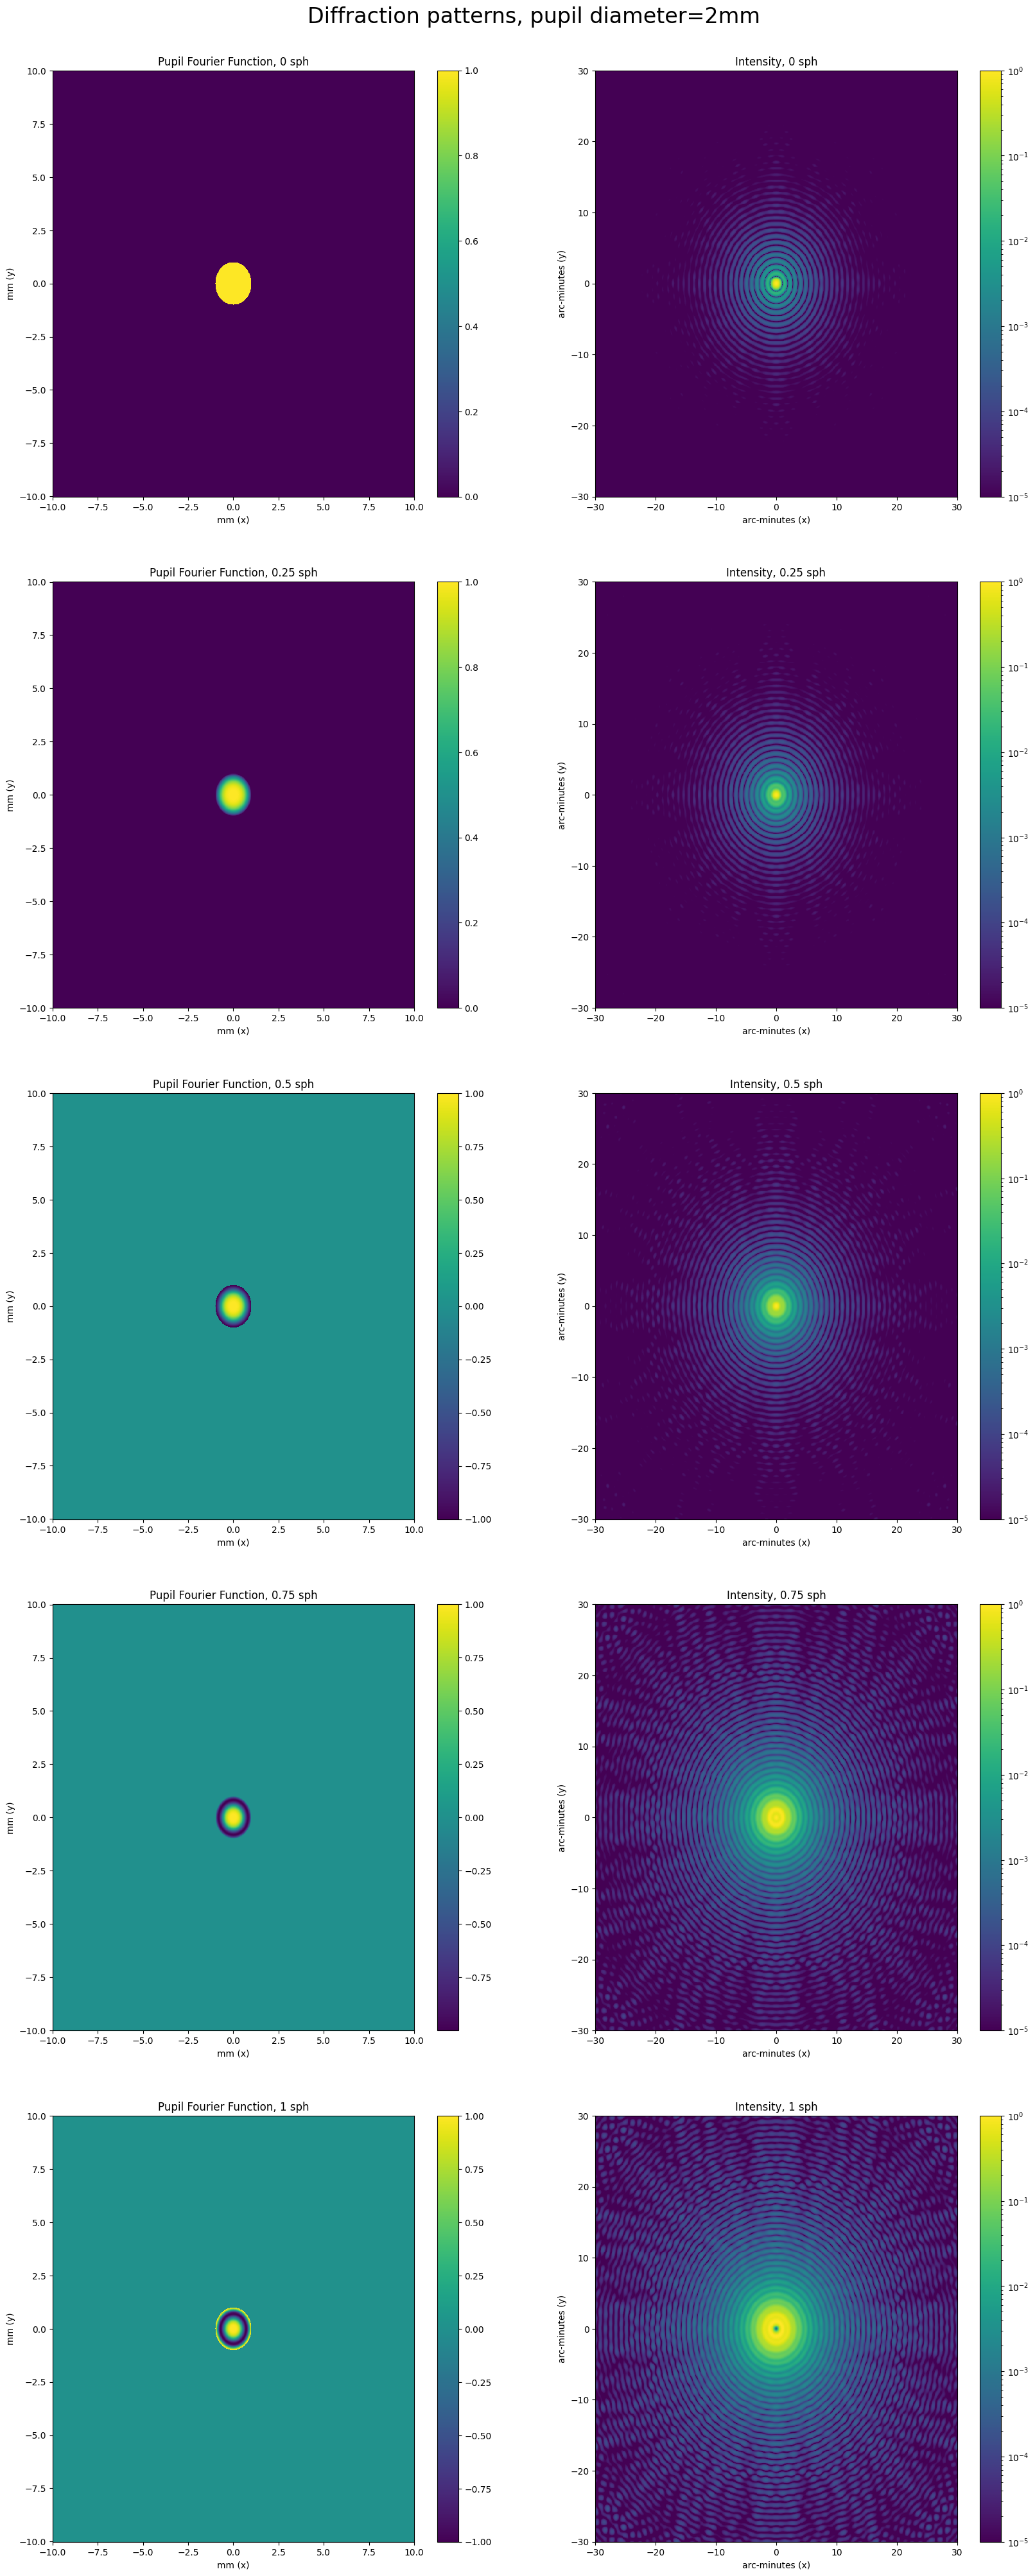

In [16]:
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import path
fig, axs = plt.subplots(5, 2, figsize=(20, 50))

d = .002 # pupil diameter, 4mm
delta_P = 1 # refractive error, diopters
wavelength = 500e-9 # 500nm
Lx = 1e-2
Ly = 1e-2
N = 1000
min_v = -Lx
max_v = Lx
L = (max_v - min_v)
d_v = L / N

max_plot_angle = 30

x,y = np.mgrid[min_v:(max_v+d_v):d_v, min_v:(max_v+d_v):d_v]

d_theta = wavelength / L
x_theta, y_theta = np.mgrid[-N/2:N/2+1:1, -N/2:N/2+1:1] * d_theta * (360/(2*np.pi)) * 60

def plot(A, ax_A, ax_I, delta_P):
    F = np.fft.fftshift(np.fft.fft2(A))
    I = np.abs(F)**2
    I = I / I.max()
    
    im_A = ax_A.pcolormesh(x*1000, y*1000, np.real(A))
    ax_A.set_xlabel('mm (x)')
    ax_A.set_ylabel('mm (y)')
    ax_A.set_title(f'Pupil Fourier Function, {delta_P} sph')
    fig.colorbar(im_A, ax=ax_A)
    
    im_I = ax_I.pcolormesh(x_theta, y_theta, I, norm=colors.LogNorm(vmin=1e-5, vmax=I.max()))
    ax_I.set_xlabel('arc-minutes (x)')
    ax_I.set_ylabel('arc-minutes (y)')
    ax_I.set_title(f'Intensity, {delta_P} sph')
    ax_I.set_xlim(-max_plot_angle, max_plot_angle)
    ax_I.set_ylim(-max_plot_angle, max_plot_angle)
    fig.colorbar(im_I, ax=ax_I)

for i, delta_P in enumerate([0, 0.25, 0.5, 0.75, 1]):
    A = np.exp(1j * 2 * np.pi * delta_P/(2 * wavelength) * (x**2+y**2) )
    A[np.sqrt(x**2+y**2)>(d/2)] = 0j
    plot(A, axs[i,0], axs[i,1], delta_P)

#fig.tight_layout()
plt.suptitle(f'Diffraction patterns, pupil diameter={int(d*1000)}mm', y=.9, fontsize=24)
plt.savefig('images/diffraction_eye.png')
plt.show()

The python cells below are for simulating and plotting refractive errors that take diffraction into account.
The first cell sets up all the hard-coded constants, and caches a 2D array called "kernels" where each element is a kernel for a given sph and cyl.
Each kernel is effectively a 2D map of intensity from a point source at different angles away from that point source.
The following cells produce 2D plots that rely on these kernels.
Since calculating the kernels takes a while, and each plot also takes a while, they have been separated into different cells.

In [81]:
import numpy as np

# main parameters to change if you want to play around with this
d = .002 # pupil diameter, mm
cyl_ax_deg = 50
wavelength = 500e-9 # 500nm
sphs = [0, 0.25, 0.5, 0.75, 1]
cyls = [0, 0.25, 0.5, 0.75, 1]

# input number is the axis of rotation of the cylindrical lens
# blur direction is 90 degree offset
# minus sign comes from flipping doctor's perspective to patient's perspective
cyl_ax = cyl_ax_deg * (2*np.pi/360)
blur_angle = np.pi/2 - cyl_ax

rad2am = 360 / (2*np.pi) * 60
am2px = 200/5 # block_letter_eye_chart has 20/20 row that is 200px high
epsilon = 1e-8

L = wavelength * rad2am * am2px

N = 2000
min_v = -L/2
max_v = L/2
d_v = L / N

x,y = np.mgrid[min_v:(max_v+epsilon):d_v, min_v:(max_v+epsilon):d_v]

phi = np.arctan2(y,x)
cyl_dist = np.sqrt(x**2+y**2) * np.cos(phi-blur_angle)

def get_kernel(sph, cyl, cyl_ax):
    A = np.exp(1j * 2 * np.pi * sph/(2 * wavelength) * (x**2+y**2) )
    A = np.multiply(A, np.exp(1j * 2 * np.pi * cyl/(2 * wavelength) * cyl_dist**2 ))
    A[np.sqrt(x**2+y**2)>(d/2)] = 0j
    
    F = np.fft.fftshift(np.fft.fft2(A))
    I = np.abs(F)**2
    I = I / I.sum()

    return I

# cache the kernels here because they take a while
kernels = []
for sph in sphs:
    curr_kernels = []
    for cyl in cyls:
        curr_kernel = get_kernel(sph, cyl, cyl_ax)
        curr_kernels.append(curr_kernel)
    kernels.append(curr_kernels)

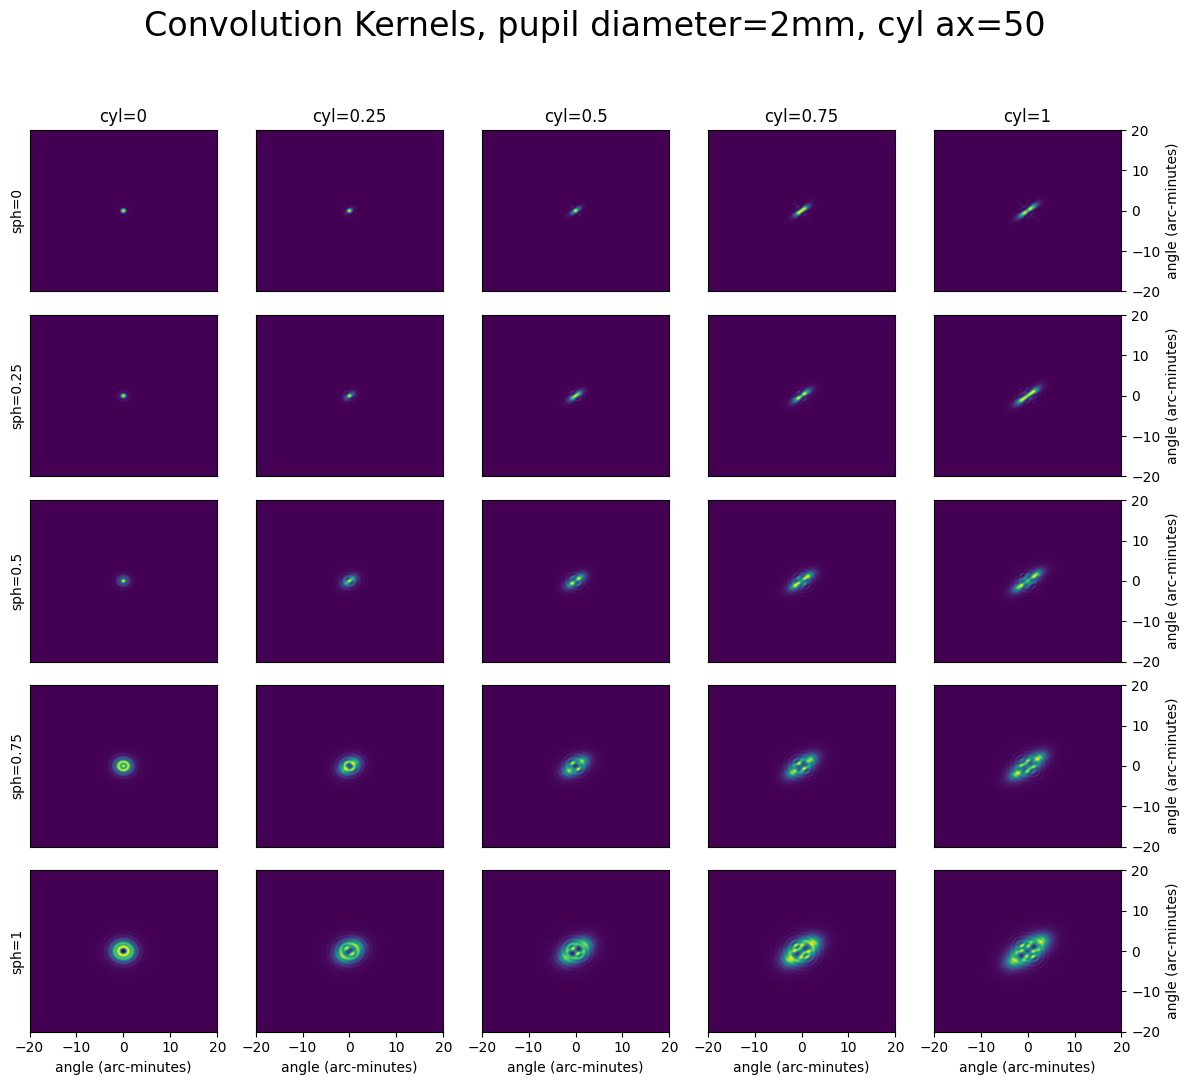

In [95]:
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import path

fig, axs = plt.subplots(len(sphs), len(cyls), figsize=(12, 12))

d_theta = wavelength / L
x_theta, y_theta = np.mgrid[-N/2:N/2+1:1, -N/2:N/2+1:1] * d_theta * (360/(2*np.pi)) * 60

max_plot_angle = 20 # arc-minutes

for i,sph in enumerate(sphs):
    for j,cyl in enumerate(cyls):
        I = kernels[i][j]
        ax_I = axs[i][j]
        im_I = ax_I.pcolormesh(x_theta, y_theta, I)
        ax_I.set_xlim(-max_plot_angle, max_plot_angle)
        ax_I.set_ylim(-max_plot_angle, max_plot_angle)
        if(i<len(sphs)-1):
            ax_I.set_xticks([])
        else:
            ax_I.set_xlabel('angle (arc-minutes)')
        if(j<len(cyls)-1):
            ax_I.set_yticks([])
        else:
            ax_I.yaxis.tick_right()
            ax_I.yaxis.set_label_position('right')
            ax_I.set_ylabel('angle (arc-minutes)')
        if(i==0):
            ax_I.set_title(f'cyl={cyl}')
        if(j==0):
            ax_I.set_ylabel(f'sph={sph}')

fig.tight_layout()
# https://stackoverflow.com/questions/8248467/tight-layout-doesnt-take-into-account-figure-suptitle
plt.subplots_adjust(top=0.8)
plt.suptitle(f'Convolution Kernels, pupil diameter={int(d*1000)}mm, cyl ax={cyl_ax_deg}', y=.9, fontsize=24)
plt.savefig('images/diffraction_kernels.png', dpi=400)
plt.show()

i:0,j:0
i:0,j:1
i:0,j:2
i:0,j:3
i:0,j:4
i:1,j:0
i:1,j:1
i:1,j:2
i:1,j:3
i:1,j:4
i:2,j:0
i:2,j:1
i:2,j:2
i:2,j:3
i:2,j:4
i:3,j:0
i:3,j:1
i:3,j:2
i:3,j:3
i:3,j:4
i:4,j:0
i:4,j:1
i:4,j:2
i:4,j:3
i:4,j:4


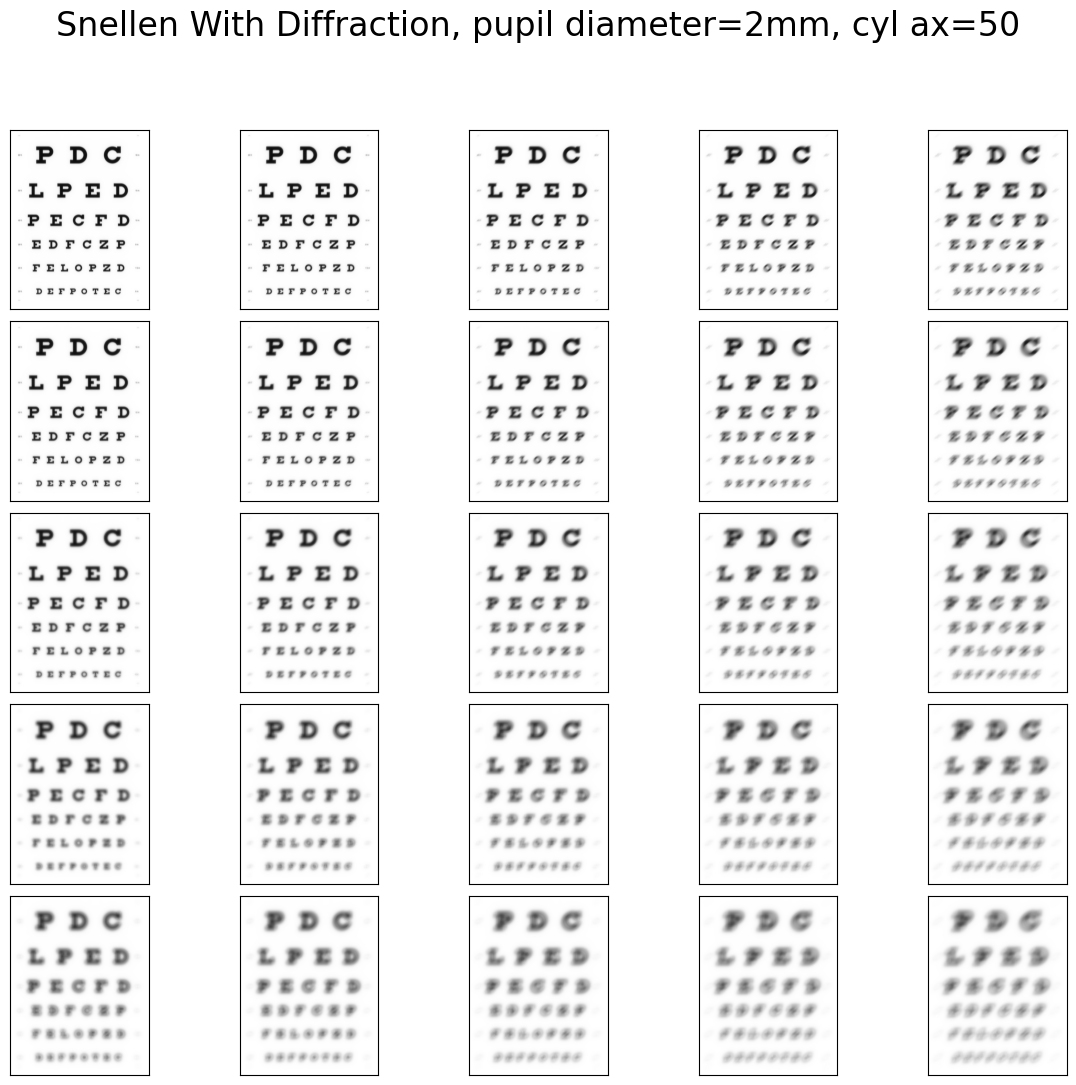

In [96]:
import cv2

img = cv2.imread('images/block_letter_eye_chart.png')

fig, axs = plt.subplots(len(sphs), len(cyls), figsize=(12, 12))

for i,sph in enumerate(sphs):
    for j,cyl in enumerate(cyls):
        print(f'i:{i},j:{j}')
        kernel = kernels[i][j].T
        ax = axs[i][j]
        dst = cv2.filter2D(img,-1,kernel[:, ::-1])
        ax.imshow(dst)
        ax.set_xticks([])
        ax.set_yticks([])
        if(i==0):
            ax_I.set_title(f'cyl={cyl}')
        if(j==0):
            ax_I.set_ylabel(f'sph={sph}')

fig.tight_layout()
# https://stackoverflow.com/questions/8248467/tight-layout-doesnt-take-into-account-figure-suptitle
plt.subplots_adjust(top=0.8)
plt.suptitle(f'Snellen With Diffraction, pupil diameter={int(d*1000)}mm, cyl ax={cyl_ax_deg}', y=.9, fontsize=24)
plt.savefig('images/diffraction_snellens.png', dpi=400)
plt.show()

In [56]:
L

0.00962569095819783